In [1]:
import pandas as pd
import paths, data

In [2]:
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-sample-3/"
transfer_files = [
    "1-2021-transfers.parquet",
    "10-2020-transfers.parquet",
    "11-2020-transfers.parquet",
    "12-2020-transfers.parquet",
    "2-2021-transfers.parquet",
    "9-2020-transfers.parquet",
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))


asid_lookup_file = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-March-2021.csv.gz"
asid_lookup = pd.read_csv(asid_lookup_file)

In [3]:
response_codes = pd.read_csv(data.gp2gp_response_codes.path)
codes = response_codes[["ErrorCode", "ErrorName"]]
transfers = transfers.merge(codes, left_on='final_error_code',right_on='ErrorCode',how='left')
transfers = transfers.rename({'ErrorName': 'requestor_error_name', 'ErrorCode': 'requestor_error'}, axis=1)
transfers = transfers.merge(codes, left_on='sender_error_code',right_on='ErrorCode',how='left')
transfers = transfers.rename({'ErrorName': 'sender_error_name', 'ErrorCode': 'sender_error'}, axis=1)

In [4]:
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

lookup = asid_lookup[["ASID", "MName"]]
transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

In [33]:
eight_days_in_seconds = 60* 60 * 24 * 8

# Assumption (that is true for this dataset) - the data was generated more than 8 days after the end of december 2020
# Therefore: All pending transfers have been pending for at least 8 days and will have triggered paper.

transfer_finished_beyond_8_days = transfers["sla_duration"] > eight_days_in_seconds
transfer_not_integrated = transfers["status"] != "INTEGRATED"
transfers_paper_fallback = transfer_finished_beyond_8_days | transfer_not_integrated
transfers["paper_fallback"] = transfers_paper_fallback

paper_fallback_counts=transfers["paper_fallback"].value_counts()
print('Total Number of Transfers:')

print(paper_fallback_counts.sum())
print('\n Total Number of Paper Fallbacks:')
print(paper_fallback_counts[True])
print('\n % with paper fallback:')
print((100*paper_fallback_counts[True]/paper_fallback_counts.sum()).round(decimals=2))


Total Number of Transfers:
1341959

 Total Number of Paper Fallbacks:
173050

 % with paper fallback:
12.9


In [6]:
total_transfers_per_supplier_pathway = transfers.pivot_table(
    index= "sending_supplier",
    columns="requesting_supplier",
    values="paper_fallback",
    aggfunc="count"
)
total_transfers_per_supplier_pathway

requesting_supplier,EMIS,Microtest,TPP,Unknown,Vision
sending_supplier,,,,,
EMIS,787302,532,257789,2050,16207
Microtest,507,129,381,9,3
TPP,236670,365,322,1716,3888
Unknown,3049,7,1849,63,56
Vision,19703,13,5008,54,4287


In [7]:
total_fallback_per_supplier_pathway = transfers.pivot_table(
    index= "sending_supplier",
    columns="requesting_supplier",
    values="paper_fallback",
    aggfunc="sum"
)
total_fallback_per_supplier_pathway

requesting_supplier,EMIS,Microtest,TPP,Unknown,Vision
sending_supplier,,,,,
EMIS,70681,466,32191,308,7953
Microtest,467,129,350,9,3
TPP,40740,358,322,477,3302
Unknown,672,7,406,15,28
Vision,9361,13,2236,26,2530


In [28]:
# % off fallback by supplier pathway
pct_of_fallback_in_supplier_pair=(total_fallback_per_supplier_pathway / total_fallback_per_supplier_pathway.sum().sum() * 100).round(decimals=2)
pct_of_fallback_in_supplier_pair

requesting_supplier,EMIS,Microtest,TPP,Unknown,Vision
sending_supplier,,,,,
EMIS,40.84,0.27,18.60,0.18,4.60
Microtest,0.27,0.07,0.20,0.01,0.00
TPP,23.54,0.21,0.19,0.28,1.91
Unknown,0.39,0.00,0.23,0.01,0.02
Vision,5.41,0.01,1.29,0.02,1.46


In [9]:
chance_of_fallback_per_supplier_pathway = transfers.pivot_table(
    index= "sending_supplier",
    columns="requesting_supplier",
    values="paper_fallback",
    aggfunc="mean"
)

pct_chance_of_fallback_per_supplier_pathway = (chance_of_fallback_per_supplier_pathway * 100).round(decimals=2)

pct_chance_of_fallback_per_supplier_pathway

requesting_supplier,EMIS,Microtest,TPP,Unknown,Vision
sending_supplier,,,,,
EMIS,8.98,87.59,12.49,15.02,49.07
Microtest,92.11,100.00,91.86,100.00,100.00
TPP,17.21,98.08,100.00,27.80,84.93
Unknown,22.04,100.00,21.96,23.81,50.00
Vision,47.51,100.00,44.65,48.15,59.02


In [10]:
paper_fallback_transfers = transfers[transfers_paper_fallback]

In [11]:
has_sender_error = paper_fallback_transfers["sender_error"].notna()
has_requestor_error = paper_fallback_transfers["requestor_error"].notna()
is_pending_error = paper_fallback_transfers["status"] == "PENDING_WITH_ERROR"
is_integrated = paper_fallback_transfers["status"] == "INTEGRATED"
is_pending = paper_fallback_transfers["status"] == "PENDING"

In [12]:
paper_fallback_transfers[is_pending_error]["sender_error"].value_counts(dropna=False)

14.0    10168
30.0     7381
10.0     3515
20.0     2840
6.0       897
7.0       723
23.0      418
19.0      311
24.0      134
NaN       126
99.0       90
21.0        2
Name: sender_error, dtype: int64

In [13]:
paper_fallback_transfers["status"].value_counts()

INTEGRATED            77124
PENDING               42061
FAILED                27260
PENDING_WITH_ERROR    26605
Name: status, dtype: int64

In [14]:
paper_fallback_transfers.loc[:, "fallback_reason"] = "other uncatagorised failure"
paper_fallback_transfers.loc[is_integrated, "fallback_reason"] = "integrated late"
paper_fallback_transfers.loc[is_pending, "fallback_reason"] = "never actioned"
paper_fallback_transfers.loc[has_sender_error, "fallback_reason"] = "sender reported failure"
paper_fallback_transfers.loc[has_requestor_error, "fallback_reason"] = "requestor reported failure"
paper_fallback_transfers["fallback_reason"].value_counts()


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


integrated late                71428
never actioned                 42061
requestor reported failure     32829
sender reported failure        26606
other uncatagorised failure      126
Name: fallback_reason, dtype: int64

In [35]:
paper_fallbacks_by_error_type_supplier_pathway=paper_fallback_transfers[["sending_supplier", "requesting_supplier", "fallback_reason"]]\
    .pivot_table(
        index=[
            "sending_supplier", "requesting_supplier",
        ],
        columns=["fallback_reason"],
        aggfunc=len,
        fill_value=0)
pct_paper_fallbacks_by_error_type_supplier_pathway=(100*paper_fallbacks_by_error_type_supplier_pathway/paper_fallbacks_by_error_type_supplier_pathway.sum().sum()).round(decimals=2)


fallback_reason                       integrated late  never actioned  \
sending_supplier requesting_supplier                                    
EMIS             EMIS                           24.34            7.81   
                 Microtest                       0.01            0.08   
                 TPP                             8.49            4.35   
                 Unknown                         0.11            0.02   
                 Vision                          0.27            0.38   
Microtest        EMIS                            0.00            0.19   
                 Microtest                       0.00            0.06   
                 TPP                             0.00            0.10   
                 Unknown                         0.00            0.00   
                 Vision                          0.00            0.00   
TPP              EMIS                            7.25            3.48   
                 Microtest                       0.00            0.02   
                 TPP                             0.00            0.15   
                 Unknown                         0.05            0.05   
                 Vision                          0.02            0.03   
Unknown          EMIS                            0.07            0.20   
                 Microtest                       0.00            0.00   
                 TPP                             0.06            0.04   
                 Unknown                         0.00            0.00   
                 Vision                          0.00            0.00   
Vision           EMIS                            0.39            4.83   
                 Microtest                       0.00            0.01   
                 TPP                             0.13            1.11   
                 Unknown                         0.00            0.01   
                 Vision                          0.09            1.37   

fallback_reason                       other uncatagorised failure  \
sending_supplier requesting_supplier                                
EMIS             EMIS                                        0.04   
                 Microtest                                   0.00   
                 TPP                                         0.00   
                 Unknown                                     0.00   
                 Vision                                      0.00   
Microtest        EMIS                                        0.00   
                 Microtest                                   0.00   
                 TPP                                         0.00   
                 Unknown                                     0.00   
                 Vision                                      0.00   
TPP              EMIS                                        0.02   
                 Microtest                                   0.00   
                 TPP                                         0.00   
                 Unknown                                     0.00   
                 Vision                                      0.00   
Unknown          EMIS                                        0.00   
                 Microtest                                   0.00   
                 TPP                                         0.00   
                 Unknown                                     0.00   
                 Vision                                      0.00   
Vision           EMIS                                        0.00   
                 Microtest                                   0.00   
                 TPP                                         0.00   
                 Unknown                                     0.00   
                 Vision                                      0.00   

fallback_reason                       requestor reported failure  \
sending_supplier requesting_supplier                               
EMIS             EMIS       

<AxesSubplot:>

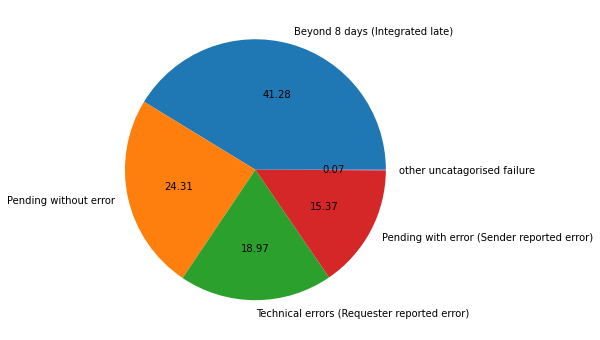

In [78]:
paper_fallback_transfers["fallback_reason"].value_counts()
relabel_error_types={"integrated late" : "Beyond 8 days (Integrated late)", "never actioned" : "Pending without error (Never actioned)" , "requestor reported failure":"Technical errors (Requester reported error)", "sender reported failure" : "Pending with error (Sender reported error)"}
relabel_error_types={"integrated late" : "Beyond 8 days (Integrated late)", "never actioned" : "Pending without error" , "requestor reported failure":"Technical errors (Requester reported error)", "sender reported failure" : "Pending with error (Sender reported error)"}

paper_fallback_transfers["fallback_reason"].value_counts().rename(relabel_error_types).rename("").plot.pie(figsize=(6,6),autopct='%.2f')

In [83]:
# Given an error between suppliers for a transfer, what is the chance of it being a particular type?
stacked_fallback_by_supplier=pd.DataFrame(total_fallback_per_supplier_pathway.stack().rename("Total PaperFallback")).loc[paper_fallbacks_by_error_type_supplier_pathway.index]
pct_paper_fallbacks_by_error_type_supplier_pathway=(100*paper_fallbacks_by_error_type_supplier_pathway.div(stacked_fallback_by_supplier['Total PaperFallback'],axis=0)).round(decimals=2)
pct_paper_fallbacks_by_error_type_supplier_pathway

fallback_reason                       integrated late  never actioned  \
sending_supplier requesting_supplier                                    
EMIS             EMIS                           59.59           19.11   
                 Microtest                       3.86           29.18   
                 TPP                            45.64           23.36   
                 Unknown                        62.01           13.31   
                 Vision                          5.81            8.36   
Microtest        EMIS                            0.43           69.38   
                 Microtest                       0.00           78.29   
                 TPP                             0.57           50.86   
                 Unknown                         0.00           22.22   
                 Vision                          0.00           66.67   
TPP              EMIS                           30.80           14.78   
                 Microtest                       0.00           10.06   
                 TPP                             0.00           80.75   
                 Unknown                        17.82           18.66   
                 Vision                          0.82            1.67   
Unknown          EMIS                           16.82           52.08   
                 Microtest                       0.00            0.00   
                 TPP                            26.35           18.47   
                 Unknown                         6.67            0.00   
                 Vision                         10.71           10.71   
Vision           EMIS                            7.25           89.27   
                 Microtest                       7.69           92.31   
                 TPP                            10.11           85.96   
                 Unknown                         7.69           92.31   
                 Vision                          5.89           93.99   

fallback_reason                       other uncatagorised failure  \
sending_supplier requesting_supplier                                
EMIS             EMIS                                        0.11   
                 Microtest                                   0.00   
                 TPP                                         0.01   
                 Unknown                                     0.00   
                 Vision                                      0.00   
Microtest        EMIS                                        0.00   
                 Microtest                                   0.00   
                 TPP                                         0.29   
                 Unknown                                     0.00   
                 Vision                                      0.00   
TPP              EMIS                                        0.11   
                 Microtest                                   0.00   
                 TPP                                         0.00   
                 Unknown                                     0.00   
                 Vision                                      0.00   
Unknown          EMIS                                        0.00   
                 Microtest                                  14.29   
                 TPP                                         0.00   
                 Unknown                                     0.00   
                 Vision                                      0.00   
Vision           EMIS                                        0.01   
                 Microtest                                   0.00   
                 TPP                                         0.00   
                 Unknown                                     0.00   
                 Vision                                      0.00   

fallback_reason                       requestor reported failure  \
sending_supplier requesting_supplier                               
EMIS             EMIS       

In [16]:
# When sender and requestor both report an error, what is the sender error
paper_fallback_transfers[has_sender_error & has_requestor_error]["sender_error_name"].value_counts()

Spine error                1042
Unauthorised req             56
Sender not LM compliant       2
SDS lookup                    1
Name: sender_error_name, dtype: int64

In [143]:
paper_fallback_sender_errors_supplier_pathway=paper_fallback_transfers\
    .loc[has_sender_error, ["sending_supplier", "requesting_supplier", "sender_error_name"]]\
    .pivot_table(
        index=[
            "sending_supplier","requesting_supplier",
        ],
        columns=["sender_error_name"],
        aggfunc=len,
        fill_value=0)
paper_fallback_sender_errors_supplier_pathway

sender_error_name                     Extract malformed  Failed to generate  \
sending_supplier requesting_supplier                                          
EMIS             EMIS                                 2                2603   
                 Microtest                            0                   1   
                 TPP                                  0                 660   
                 Unknown                              0                   6   
                 Vision                               0                  58   
Microtest        EMIS                                 0                  52   
                 Microtest                            0                  18   
                 TPP                                  0                  59   
                 Unknown                              0                   2   
                 Vision                               0                   0   
TPP              EMIS                                 0                   0   
                 Microtest                            0                   0   
                 TPP                                  0                   0   
                 Unknown                              0                   0   
                 Vision                               0                   0   
Unknown          EMIS                                 0                  30   
                 Microtest                            0                   2   
                 TPP                                  0                  20   
                 Unknown                              0                   1   
                 Vision                               0                   0   
Vision           EMIS                                 0                   1   
                 TPP                                  0                   2   
                 Vision                               0                   0   

sender_error_name                     GP2GP disabled  LM general failure  \
sending_supplier requesting_supplier                                       
EMIS             EMIS                            289                   0   
                 Microtest                         3                   0   
                 TPP                              71                   0   
                 Unknown                           2                   0   
                 Vision                           70                   0   
Microtest        EMIS                              0                   0   
                 Microtest                         0                   0   
                 TPP                               0                   0   
                 Unknown                           0                   0   
                 Vision                            0                   0   
TPP              EMIS                             59                7159   
                 Microtest                         0                  16   
                 TPP                              60                   0   
                 Unknown                          63                  77   
                 Vision                            5                 105   
Unknown          EMIS                             44                  23   
                 Microtest                         0                   0   
                 TPP                              49                   0   
                 Unknown                           0                   1   
                 Vision                            8                   0   
Vision           EMIS                              0                   0   
                 TPP                               0                   0   
                 Vision                            0                   0   

sender_error_name                     Not at surgery  Req not LM compliant  \
sending_supplier requesting_supplier         

In [142]:
print(has_sender_error.sum())
# Given a sender reported error for a transfer between suppliers, what is the likely problem?
(100*paper_fallback_sender_errors_supplier_pathway.div(paper_fallbacks_by_error_type_supplier_pathway['sender reported failure'],axis=0)).round(decimals=2)


27707


sender_error_name                     Extract malformed  Failed to generate  \
sending_supplier requesting_supplier                                          
EMIS             EMIS                              0.04               46.37   
                 Microtest                         0.00                0.33   
                 TPP                               0.00               37.82   
                 Unknown                           0.00               18.18   
                 Vision                            0.00                0.89   
Microtest        EMIS                              0.00               38.52   
                 Microtest                         0.00               64.29   
                 TPP                               0.00               34.91   
                 Unknown                           0.00               28.57   
                 Vision                            0.00                0.00   
TPP              EMIS                              0.00                0.00   
                 Microtest                         0.00                0.00   
                 TPP                               0.00                0.00   
                 Unknown                           0.00                0.00   
                 Vision                            0.00                0.00   
Unknown          EMIS                              0.00               19.35   
                 Microtest                         0.00               33.33   
                 TPP                               0.00               19.61   
                 Unknown                           0.00               10.00   
                 Vision                            0.00                0.00   
Vision           EMIS                              0.00                1.11   
                 Microtest                          NaN                 NaN   
                 TPP                               0.00                6.90   
                 Unknown                            NaN                 NaN   
                 Vision                            0.00                0.00   

sender_error_name                     GP2GP disabled  LM general failure  \
sending_supplier requesting_supplier                                       
EMIS             EMIS                           5.15                0.00   
                 Microtest                      0.98                0.00   
                 TPP                            4.07                0.00   
                 Unknown                        6.06                0.00   
                 Vision                         1.07                0.00   
Microtest        EMIS                           0.00                0.00   
                 Microtest                      0.00                0.00   
                 TPP                            0.00                0.00   
                 Unknown                        0.00                0.00   
                 Vision                         0.00                0.00   
TPP              EMIS                           0.75               91.21   
                 Microtest                      0.00                4.98   
                 TPP                           96.77                0.00   
                 Unknown                       37.06               45.29   
                 Vision                         0.16                3.27   
Unknown          EMIS                          28.39               14.84   
                 Microtest                      0.00                0.00   
                 TPP                           48.04                0.00   
                 Unknown                        0.00               10.00   
                 Vision                        36.36                0.00   
Vision           EMIS                           0.00                0.00   
                 Microtest                       NaN                 NaN   
                 TPP                      

In [18]:
paper_fallback_transfers\
    .loc[has_requestor_error, ["sending_supplier", "requesting_supplier", "requestor_error_name"]]\
    .pivot_table(
        index=[
            "sending_supplier", "requesting_supplier",
        ],
        columns=["requestor_error_name"],
        aggfunc=len,
        fill_value=0
)

requestor_error_name                  ABA supressed  ABA wrong patint  \
sending_supplier requesting_supplier                                    
EMIS             EMIS                          4245               562   
                 Microtest                        0                 0   
                 TPP                              0                25   
                 Unknown                         16                 7   
                 Vision                           0                 0   
Microtest        EMIS                             0                 0   
TPP              EMIS                          1220               172   
                 Microtest                        0                 0   
                 Unknown                          8                 6   
                 Vision                           0                 0   
Unknown          EMIS                            12                 1   
                 TPP                              0                 0   
                 Unknown                          0                 1   
Vision           EMIS                            68                 3   
                 TPP                              0                 0   
                 Vision                           0                 0   

requestor_error_name                  Duplicate EHR  Extract malformed  \
sending_supplier requesting_supplier                                     
EMIS             EMIS                          1527                  6   
                 Microtest                        0                  0   
                 TPP                           4620                  0   
                 Unknown                          6                  0   
                 Vision                         216                  0   
Microtest        EMIS                             0                  0   
TPP              EMIS                           144                 31   
                 Microtest                        0                  0   
                 Unknown                          1                  1   
                 Vision                           2                  0   
Unknown          EMIS                            15                  0   
                 TPP                             75                  0   
                 Unknown                          2                  0   
Vision           EMIS                             1                132   
                 TPP                              1                  0   
                 Vision                           1                  0   

requestor_error_name                  Failed to integrate  \
sending_supplier requesting_supplier                        
EMIS             EMIS                                 285   
                 Microtest                              6   
                 TPP                                  421   
                 Unknown                                1   
                 Vision                                66   
Microtest        EMIS                                   0   
TPP              EMIS                                  73   
                 Microtest                              1   
                 Unknown                                3   
                 Vision                                10   
Unknown          EMIS                                   1   
                 TPP                                    5   
                 Unknown                                0   
Vision           EMIS                                   9   
                 TPP                                    1   
                 Vision                                 0   

requestor_error_name                  Filed as attachment  LM general failure  \
sending_supplier requesting_supplier                                            
EMIS             EMIS                                  56                   0   
          

In [98]:
Integrated_late_by_supplier=pd.pivot_table(paper_fallbacks_by_error_type_supplier_pathway,index='sending_supplier',columns='requesting_supplier',values='integrated late')
Integrated_late_by_supplier=Integrated_late_by_supplier.loc[total_transfers_per_supplier_pathway.index,total_transfers_per_supplier_pathway.columns]
pct_chance_integrated_late=(100*Integrated_late_by_supplier/total_transfers_per_supplier_pathway).round(decimals=2)
pct_chance_integrated_late

requesting_supplier,EMIS,Microtest,TPP,Unknown,Vision
sending_supplier,,,,,
EMIS,5.35,3.38,5.70,9.32,2.85
Microtest,0.39,0.00,0.52,0.00,0.00
TPP,5.30,0.00,0.00,4.95,0.69
Unknown,3.71,0.00,5.79,1.59,5.36
Vision,3.45,7.69,4.51,3.70,3.48


In [97]:
Inaction_by_supplier=pd.pivot_table(paper_fallbacks_by_error_type_supplier_pathway,index='sending_supplier',columns='requesting_supplier',values='never actioned')
Inaction_by_supplier=Inaction_by_supplier.loc[total_transfers_per_supplier_pathway.index,total_transfers_per_supplier_pathway.columns]
pct_chance_inaction=(100*Inaction_by_supplier/total_transfers_per_supplier_pathway).round(decimals=2)
pct_chance_inaction

requesting_supplier,EMIS,Microtest,TPP,Unknown,Vision
sending_supplier,,,,,
EMIS,1.72,25.56,2.92,2.00,4.10
Microtest,63.91,78.29,46.72,22.22,66.67
TPP,2.54,9.86,80.75,5.19,1.41
Unknown,11.48,0.00,4.06,0.00,5.36
Vision,42.41,92.31,38.38,44.44,55.47


In [108]:
sending_practices_fallback_rates=transfers.groupby(['sending_supplier','sending_practice_asid']).agg({'paper_fallback':['count','mean']})['paper_fallback'].rename({'mean':'sending fallback %','count':'total sending'},axis=1).reset_index()
requesting_practices_fallback_rates=transfers.groupby(['requesting_supplier','requesting_practice_asid']).agg({'paper_fallback':['count','mean']})['paper_fallback'].rename({'mean':'requesting fallback %','count':'total requesting'},axis=1).reset_index()
transfer_rates_by_practice=sending_practices_fallback_rates.merge(requesting_practices_fallback_rates,left_on='sending_practice_asid',right_on='requesting_practice_asid',how='outer')


<AxesSubplot:ylabel='Frequency'>

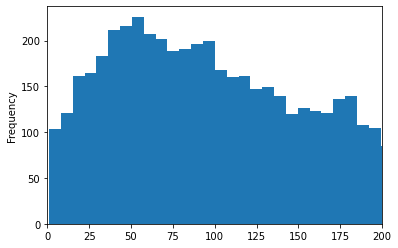

In [123]:
transfer_rates_by_practice['total requesting'].plot.hist(bins=1000,xlim=[0,200])

<AxesSubplot:ylabel='Frequency'>

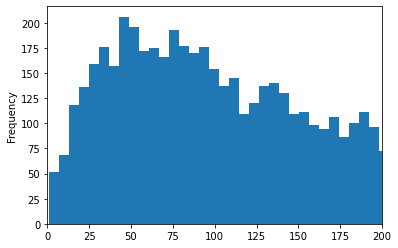

In [124]:
transfer_rates_by_practice['total sending'].plot.hist(bins=1000,xlim=[0,200])

<AxesSubplot:ylabel='Frequency'>

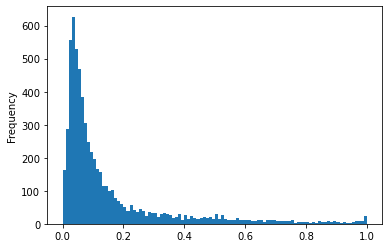

In [128]:
transfer_rates_by_practice.loc[transfer_rates_by_practice['total requesting']>25,'requesting fallback %'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

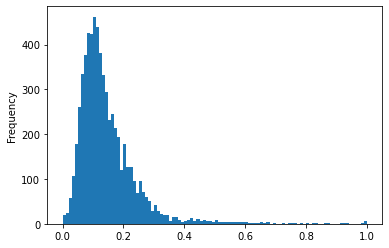

In [130]:
transfer_rates_by_practice.loc[transfer_rates_by_practice['total sending']>25,'sending fallback %'].plot.hist(bins=100)

<AxesSubplot:xlabel='total requesting', ylabel='requesting fallback %'>

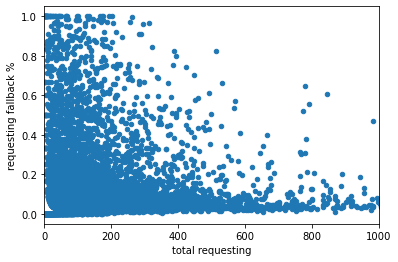

In [132]:
transfer_rates_by_practice.plot.scatter(x='total requesting',y='requesting fallback %',xlim=[0,1000])

<AxesSubplot:xlabel='total sending', ylabel='sending fallback %'>

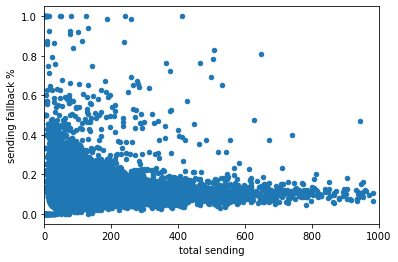

In [136]:
# Do larger practices tend to have higher fall back rates?
transfer_rates_by_practice.plot.scatter(x='total sending',y='sending fallback %',xlim=[0,1000])

In [ ]:
# User experience research - understand why practices have high inaction (pending without error) or late integration rates
# Focus on one supplier eg EMIS and maybe just EMIS-EMIS & EMIS-TPP transfers
# Select EMIS practices with an interquartile range of sending requests to other EMIS and TPP practices
# Rank them by their total inaction or late integration rates
